# Using pre-trained model

In [43]:
from multimodal.multimodal_lit import MultiModalLitModel
from tqdm import tqdm
from PIL import Image

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import torch
import cv2
import os
import re

In [44]:
os.environ["HF_ENDPOINT"]="https://hf-mirror.com"

In [45]:
BASE_PATH = 'D:\\VSCode Projects\\jupyter\\Big Data and Multi-modal Data Fusion'
DATASET_PATH = 'dataset'
VIDEO_PATH = 'video'
SCREENSHOT_PATH ='screenshots'
TRANSCRIPT_PATH = 'merged_transcripts.xlsx'

In [46]:
# time process function
def time_process(t: str):
    t = t.strip()
    if '-' in t:
        t1, t2 = t.split('-')
        t = (time_process(t1) + time_process(t2)) // 2
    else:
        t = t.split(':')
        t = (int(t[0]) * 60 if t[0].isdigit() else 0) + (int(t[1]) if len(t) > 1 and t[1].isdigit() else 0)
    return t

# process image
def process_image(img_path: str):
    assert os.path.exists(img_path), f"Image '{img_path}' does not exist"
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = np.array(img)
    assert img.shape == (480, 640, 3), f"Image shape is {img.shape}, not (480, 640, 3)."
    return img

# process utterance
def process_utterance(utterance: str):
    utterance = utterance.lower()
    utterance = re.sub(r'[^\w\s]', '', utterance)
    utterance = [word for word in utterance.strip().split(' ') if word != '']
    return utterance

In [47]:
df = pd.read_excel(os.path.join(BASE_PATH, TRANSCRIPT_PATH))
# df = df[df['Speaker'].isin(['S', 'sam', 'Sam', 'Video (S)', 'child']) & df['Child Age']].reset_index(drop=True)

images_labels = []
texts_labels = []
for i in tqdm(range(len(df)), desc='Processing images and texts'):
    video_name = df.at[i, 'Video Name']
    time = time_process(str(df.at[i, 'Time']))
    screeshot_path = os.path.join(BASE_PATH, SCREENSHOT_PATH, video_name.split('.')[0], str(time) + '.jpg')
    if not os.path.exists(screeshot_path): continue
    # images_labels.append(process_image(screeshot_path))

    utterance = df.at[i, 'Utterance']
    [texts_labels.append(text) for text in process_utterance(utterance)]

Processing images and texts: 100%|██████████| 5398/5398 [00:00<00:00, 31436.50it/s]


In [48]:
images_labels.append(process_image(os.path.join(BASE_PATH, SCREENSHOT_PATH, 'S_20130901_1015_01\\743.jpg')))

In [49]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

cvcl, preprocess = MultiModalLitModel.load_model(model_name="cvcl")
cvcl = cvcl.to(device)
cvcl.eval()

# create random image to encode
# image_labels = torch.rand(4, 3, 224, 224)
images_labels = torch.tensor(np.array(images_labels), dtype=torch.float32)
images_labels = images_labels.permute(0, 3, 1, 2)
images = images_labels.to(device)
image_features = cvcl.encode_image(images)

# create texts to encode
# texts_labels = ["ball", "puzzle", "car"]
texts_labels = list(dict.fromkeys(texts_labels))
texts, texts_len = cvcl.tokenize(texts_labels)
texts, texts_len = texts.to(device), texts_len.to(device)
texts_features = cvcl.encode_text(texts, texts_len)

# get logits from a batch of images and texts
logits_per_image, logits_per_text = cvcl(images, texts, texts_len)

probs = logits_per_image.softmax(dim=-1).detach().cpu().numpy()

Lightning automatically upgraded your loaded checkpoint from v1.5.8 to v2.4.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint C:\Users\Naturean\.cache\huggingface\hub\models--wkvong--cvcl_s_dino_resnext50_embedding\snapshots\f50eaa0c50a6076a5190b1dd52aeeb6c3e747045\cvcl_s_dino_resnext50_embedding.ckpt`
d:\Anaconda\envs\multimodal-baby\Lib\site-packages\pytorch_lightning\utilities\parsing.py:208: Attribute 'vision_encoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['vision_encoder'])`.
d:\Anaconda\envs\multimodal-baby\Lib\site-packages\pytorch_lightning\utilities\parsing.py:208: Attribute 'text_encoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['text_encoder'])`.


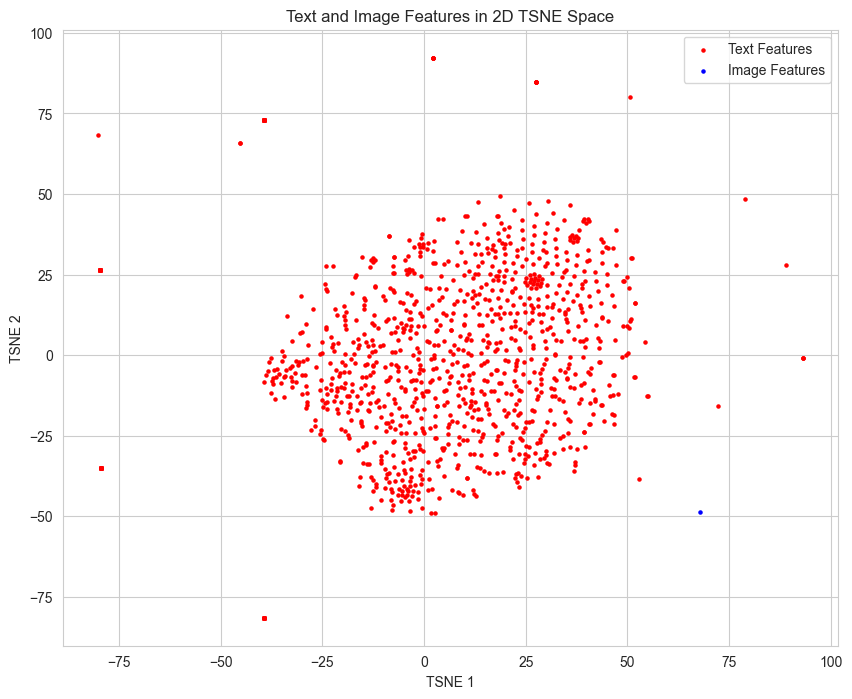

In [50]:
from sklearn.manifold import TSNE

combined_features = np.concatenate((texts_features.detach().cpu().numpy(), image_features.detach().cpu().numpy()), axis=0)

tsne = TSNE(n_components=2, random_state=0)
combined_features_2d = tsne.fit_transform(combined_features)

texts_features_2d = combined_features_2d[:len(texts_features)]
image_features_2d = combined_features_2d[len(texts_features):]

plt.figure(figsize=(10, 8))
plt.scatter(texts_features_2d[:, 0], texts_features_2d[:, 1], c='r', label='Text Features', s=5)
plt.scatter(image_features_2d[:, 0], image_features_2d[:, 1], c='b', label='Image Features', s=5)

plt.title('Text and Image Features in 2D TSNE Space')
plt.xlabel('TSNE 1')
plt.ylabel('TSNE 2')
plt.legend()
plt.grid(True)
plt.show()


In [51]:
k = 5
top_k_indices = np.unravel_index(np.argsort(probs, axis=None)[-k:], probs.shape)

image_indices = top_k_indices[0]
text_indices = top_k_indices[1]

for i in range(k - 1, -1, -1):
    _image = df.at[image_indices[i], 'Video Name'].split('.')[0] + '/' + str(time_process(df.at[image_indices[i], 'Time'])) + '.jpg'
    _text = texts_labels[text_indices[i]]
    print(f"[{k - i}] image: {_image}, text: {_text}, prob: {probs[image_indices[i], text_indices[i]]}")

[1] image: S_20130417_0600_01/3.jpg, text: uhhumahhehhheomnn, prob: 0.0019397455034777522
[2] image: S_20130417_0600_01/3.jpg, text: abamammyhmmmaamma, prob: 0.0019397455034777522
[3] image: S_20130417_0600_01/3.jpg, text: yee, prob: 0.001939745037816465
[4] image: S_20130417_0600_01/3.jpg, text: heeeeh, prob: 0.001939745037816465
[5] image: S_20130417_0600_01/3.jpg, text: gaga, prob: 0.001939745037816465


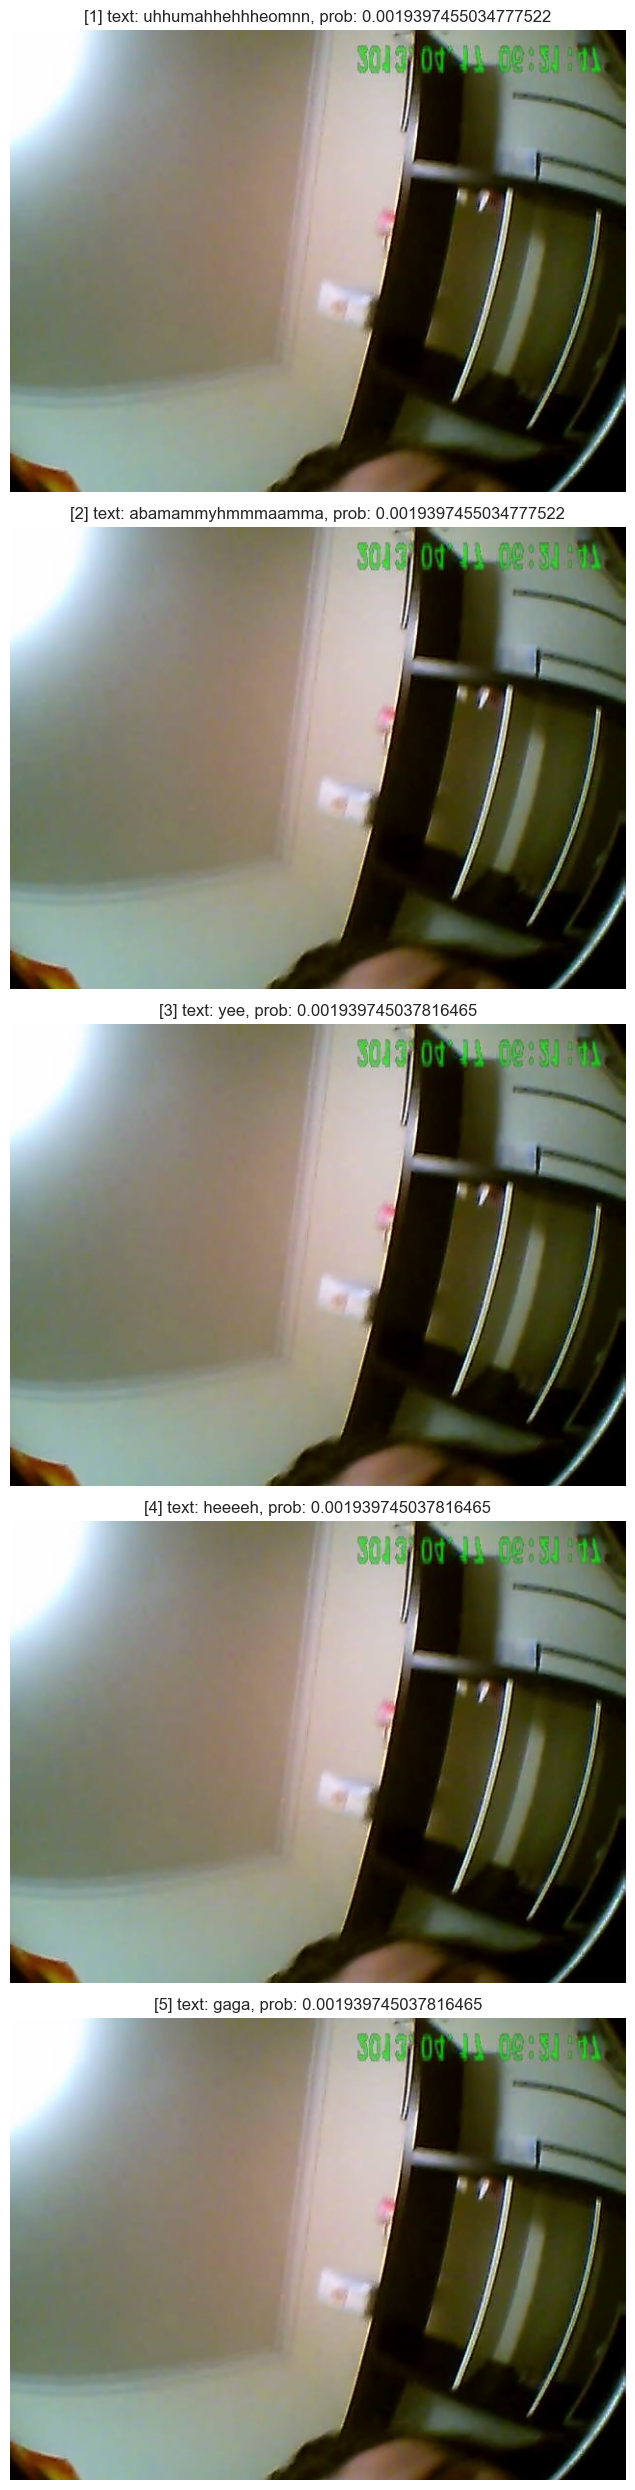

In [52]:
plt.figure(figsize=(15, 5 * k))
for i in range(k - 1, -1, -1):
    image_path = os.path.join(BASE_PATH, SCREENSHOT_PATH, df.at[image_indices[i], 'Video Name'].split('.')[0], str(time_process(df.at[image_indices[i], 'Time'])) + '.jpg')
    img = Image.open(image_path)
    text_label = f"[{k - i}] text: {texts_labels[text_indices[i]]}, prob: {probs[image_indices[i], text_indices[i]]}"

    plt.subplot(k, 1, k - i)
    plt.imshow(img)
    plt.axis('off')
    plt.title(text_label)

plt.tight_layout()
plt.show()


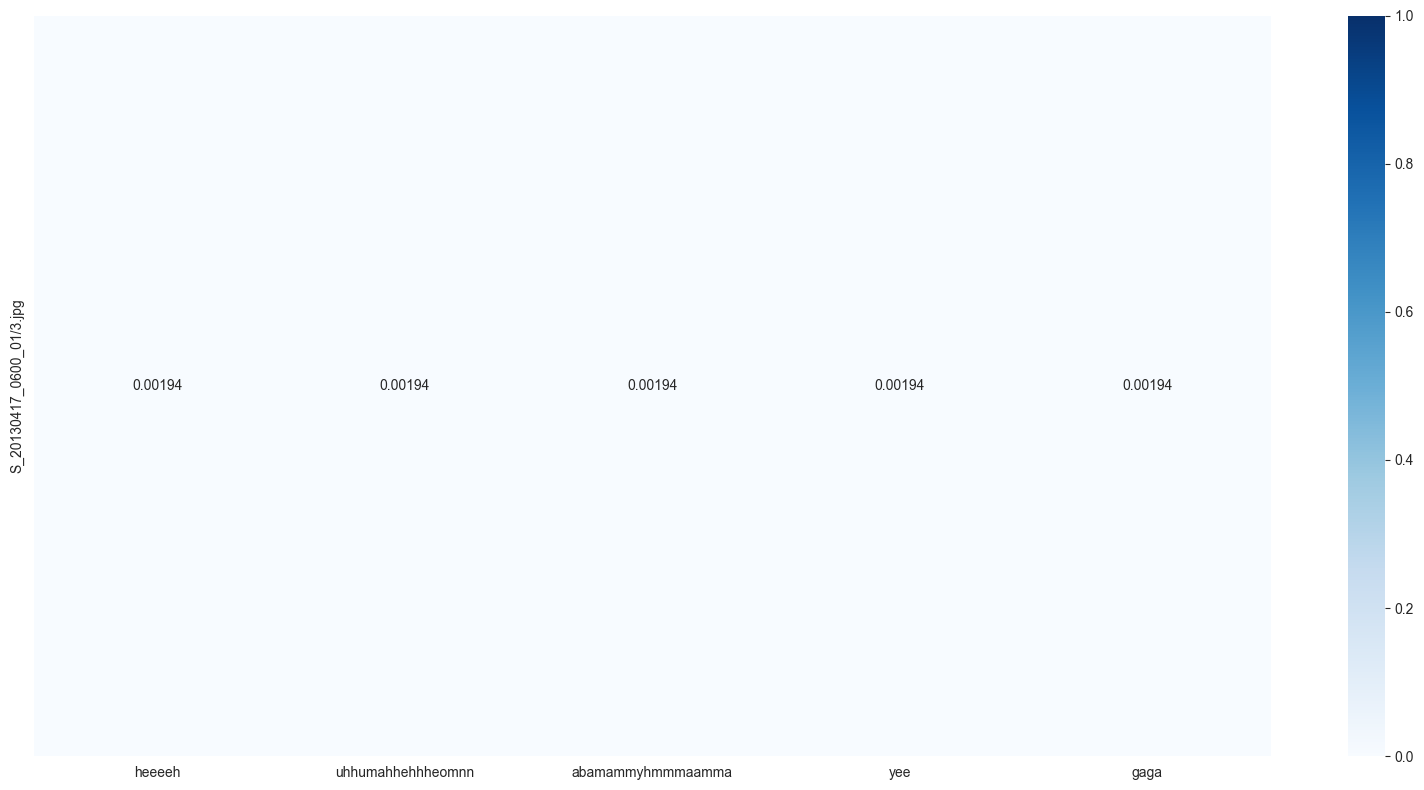

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt

image_indices = np.unique(image_indices)
text_indices = np.unique(text_indices)
probs_matrix = np.zeros((len(image_indices), len(text_indices)))

for i, image_index in enumerate(image_indices):
    for j, text_index in enumerate(text_indices):
        probs_matrix[i, j] = probs[image_index, text_index]

text_labels = [texts_labels[i] for i in text_indices]
image_labels = [df.at[i, 'Video Name'].split('.')[0] + '/' + str(time_process(df.at[i, 'Time'])) + '.jpg' for i in image_indices]

sns.set_style("whitegrid")
plt.figure(figsize=(16, 8))
sns.heatmap(probs_matrix, annot=True, cmap='Blues', xticklabels=text_labels, yticklabels=image_labels, vmax=1.0, vmin=0.0, fmt='.5f')
plt.tight_layout()
plt.show()